In [1]:
@file:DependsOnMaven("net.imagej:ij:1.51g")

In [2]:
@file:DependsOnMaven("de.hanslovsky:z_spacing-spark-experiments:0.0.1-SNAPSHOT")

In [3]:
@file:DependsOnMaven("sc.fiji:Trainable_Segmentation:3.2.4")

In [4]:
@file:DependsOnMaven("net.imglib2:imglib2-ij:2.0.0-beta-35")

In [5]:
import java.io.ByteArrayOutputStream;
import java.util.ArrayList;
import java.util.Arrays;
import java.util.List;
import java.util.concurrent.Callable;
import java.util.concurrent.ExecutorService;
import java.util.concurrent.Executors;
import java.util.concurrent.Future;

import javax.imageio.ImageIO;
import javax.xml.bind.DatatypeConverter;

import bdv.util.BdvFunctions;
import bdv.util.BdvOptions;
import bdv.util.BdvStackSource;

import de.hanslovsky.zspacing.spark.experiments.mask.WekaClassifierMaskGenerator;
import de.hanslovsky.zspacing.spark.experiments.mask.weka.InstanceView;


import ij.ImageJ;
import ij.ImagePlus;

import net.imglib2.RandomAccessibleInterval;
import net.imglib2.converter.Converters;
import net.imglib2.converter.RealARGBConverter;
import net.imglib2.img.array.ArrayImg;
import net.imglib2.img.array.ArrayImgs;
import net.imglib2.img.basictypeaccess.array.DoubleArray;
import net.imglib2.img.display.imagej.ImageJFunctions;
import net.imglib2.type.numeric.ARGBType;
import net.imglib2.type.numeric.NumericType;
import net.imglib2.type.numeric.real.DoubleType;
import net.imglib2.type.numeric.real.FloatType;
import net.imglib2.util.Intervals;
import net.imglib2.view.IntervalView;
import net.imglib2.view.Views;
import net.imglib2.view.composite.RealComposite;

In [6]:
fun< T : NumericType<T> > toBase64(ra: RandomAccessibleInterval< T >): Pair<String, Any> {
    val os = ByteArrayOutputStream();
    val bi = ImageJFunctions.wrap( ra, "" ).duplicate().getBufferedImage();
    ImageIO.write(bi, "png", os);
    val str = DatatypeConverter.printBase64Binary(os.toByteArray());
    val mime = "image/png";
    return mime to str;
}

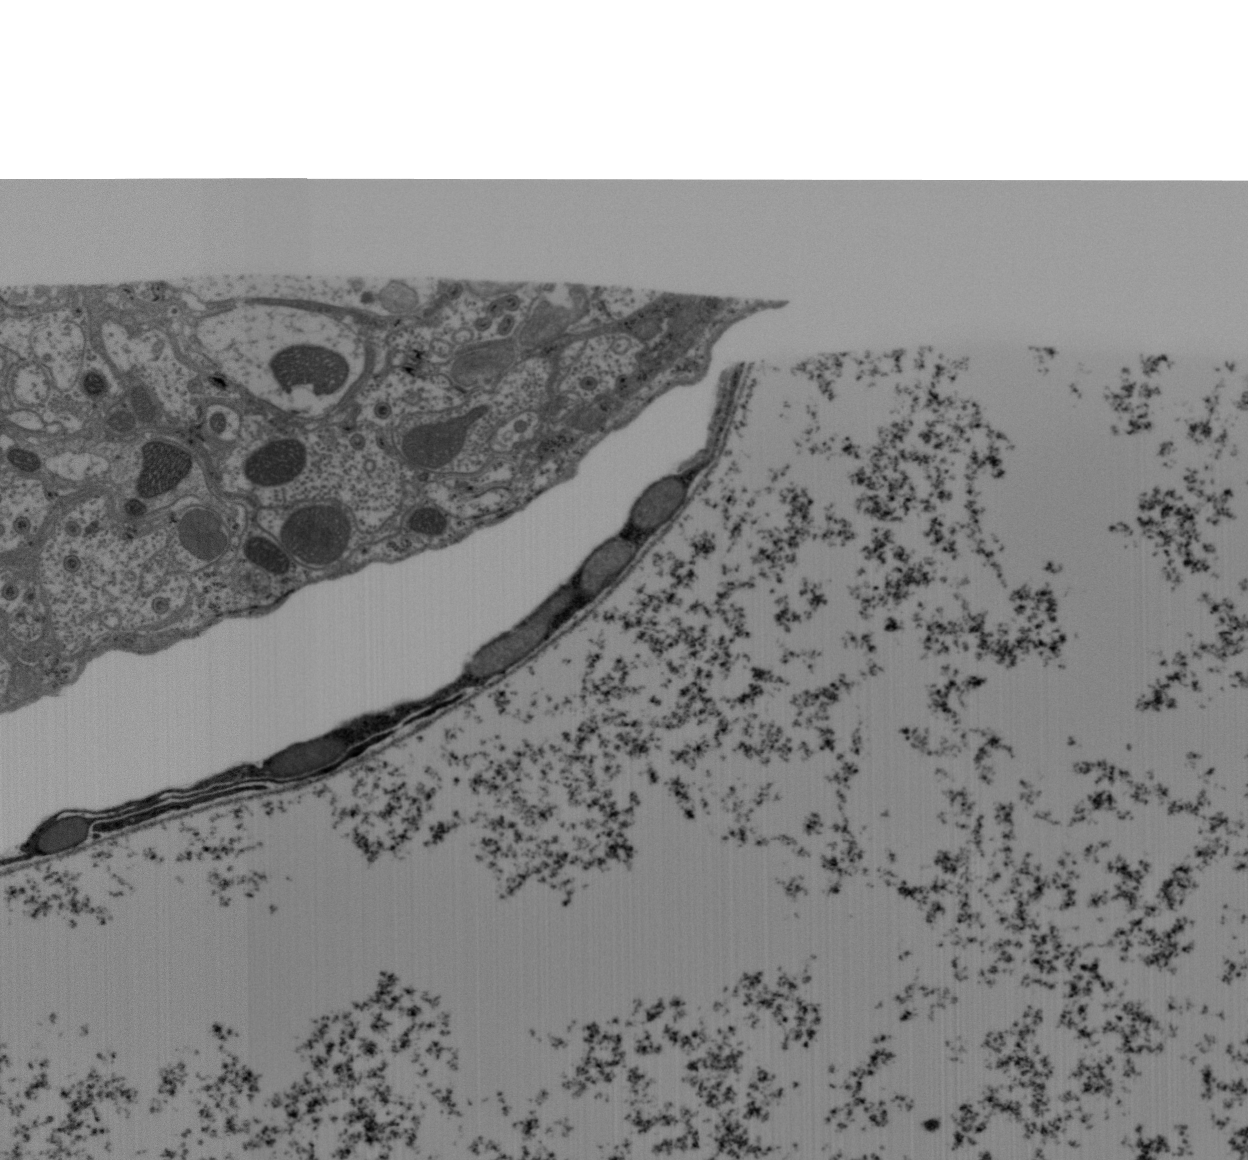

In [7]:
val classifierPath = "/data/hanslovskyp/weka-test/grayvalue.model";
val imgPath = "/data/hanslovskyp/weka-test/img.tif";
val img = ImageJFunctions.wrapFloat( ImagePlus( imgPath ) );
val imgComposite = Views.collapseReal( Views.addDimension( img, 0, 0 ) );
val instances = InstanceView<FloatType>( imgComposite, InstanceView.makeDefaultAttributes( 1, 2 ) );
val mask = ArrayImgs.doubles( *Intervals.dimensionsAsLongArray( img ) );

val conv = RealARGBConverter<FloatType>(0.0, 255.0);
resultOf( toBase64( Converters.convert( img as RandomAccessibleInterval< FloatType >, conv, ARGBType() ) ) )

In [8]:
val nThreads = Runtime.getRuntime().availableProcessors() - 1;
val stepSize = img.dimension( 1 ) / nThreads;
val tasks = ArrayList< Callable< Long > >();

val generator = WekaClassifierMaskGenerator< DoubleType >( classifierPath, 0 );


val y = 0 as Long;
while ( y < img.dimension( 1 ) )
{
	val interval = Views.interval( mask, longArrayOf( 0L, y as Long ), longArrayOf( img.max( 0 ), Math.min( y + stepSize - 1, img.max( 1 ) ) ) );
	tasks.add( object : Callable< Long > {
        override fun call() : Long {
            generator.generateMask( instances, interval );
            return 0L;
        }
	} );
    y += stepSize;
}

In [9]:
val es = Executors.newFixedThreadPool( nThreads );
val fs = es.invokeAll( tasks );
for ( f in fs )
	f.get();

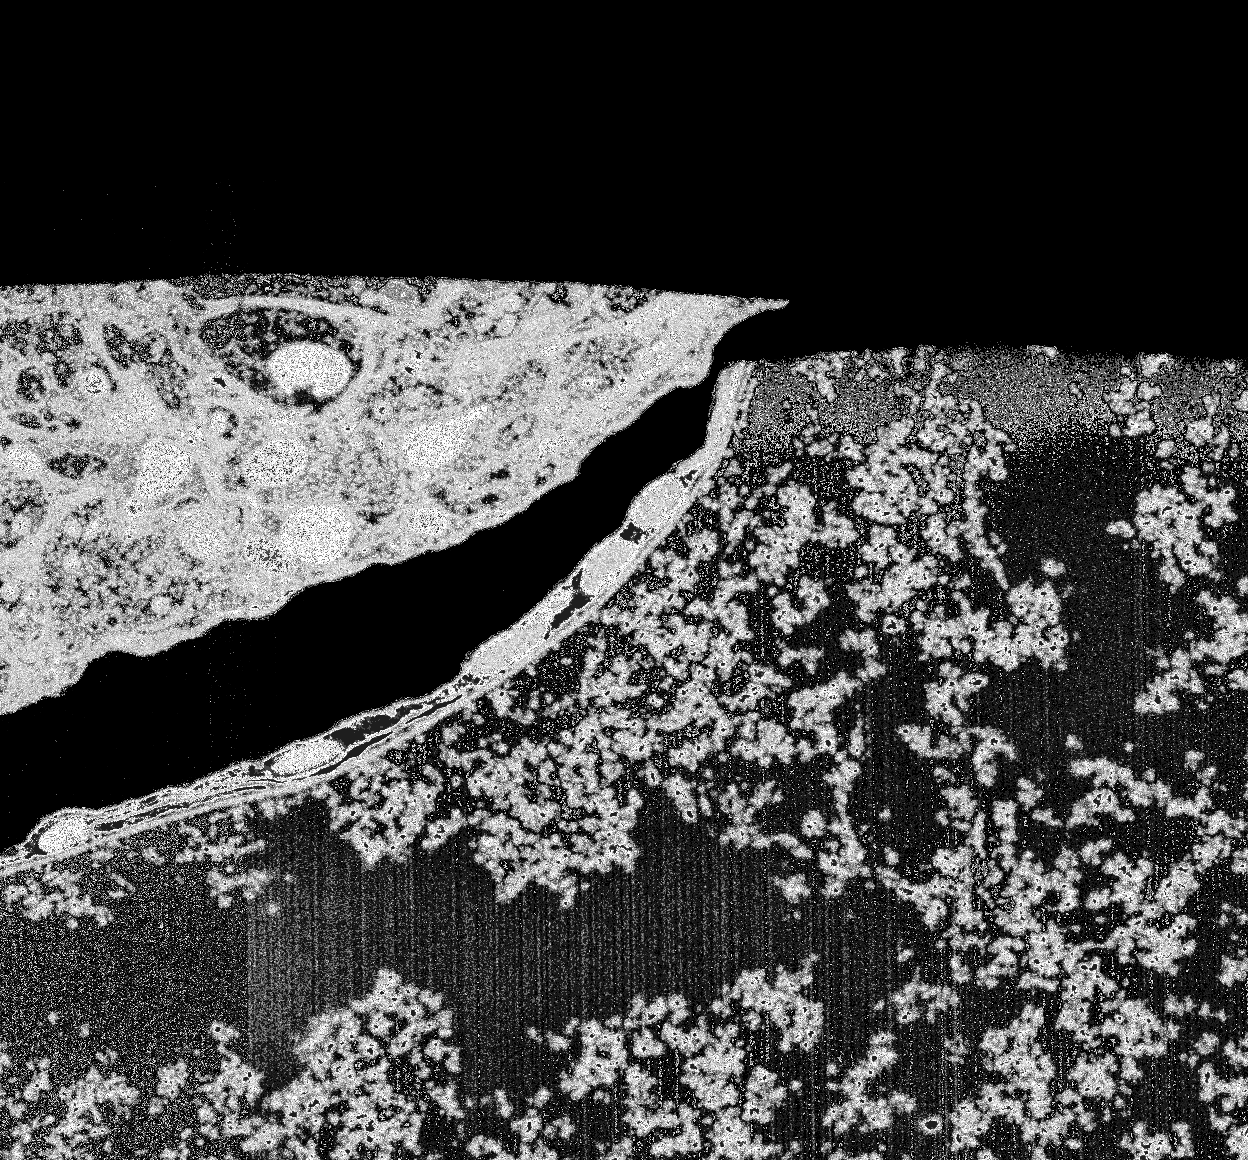

In [10]:
val conv2 = RealARGBConverter< DoubleType >( 0.0, 1.0 );
resultOf( toBase64( Converters.convert( mask as RandomAccessibleInterval< DoubleType >, conv2, ARGBType() ) ) )